### Programming Homework 1 - Training Binary Classification w/ MNIST
#### LO, Li-yu 20997405 w/ lloac@connect.hkust.hk

In [320]:
#Don't change batch size
batch_size = 64

from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms

Download Binary Train/Test Data

In [321]:
# load train and test data
train_data = datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_data = datasets.MNIST('./data/mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# load only class 0 and 1
# and separate them into mini-batches, with batch size = 64
subset_indices_train = ((train_data.train_labels == 0) + (train_data.train_labels == 1)).nonzero().reshape(-1)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=False,sampler=SubsetRandomSampler(subset_indices_train))

subset_indices_test = ((test_data.test_labels == 0) + (test_data.test_labels == 1)).nonzero().reshape(-1)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size, shuffle=False,sampler=SubsetRandomSampler(subset_indices_test))

print(f"Train Data size: {len(subset_indices_train)}")
print(f"Test  Data size: {len(subset_indices_test)}")

print(f"Train no. of total batches: {len(train_loader)}")
print(f"Test  no. of total batches: {len(test_loader)}")


Train Data size: 12665
Test  Data size: 2115
Train no. of total batches: 198
Test  no. of total batches: 34


visualize data

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
torch.Size([28, 28])


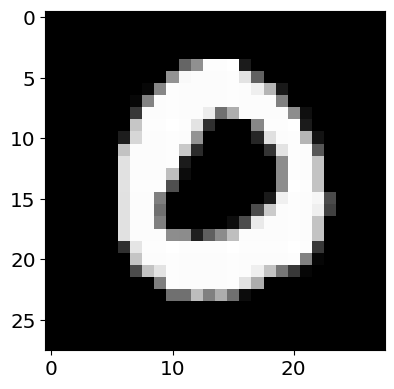

Label: 0


In [322]:
import matplotlib.pyplot as plt

# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
print(img.size())
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Hyper Parameters Settings

In [361]:
# model_option = "LR"
model_option = "SVM"

# optimize_option = "SGD"
optimize_option = "SGD-M"

alpha_lr = 0.01
beta_momentum = 0.9

Test Model

In [362]:
# Test the Model
def test_model(W, accuracy_of_all):
    correct = 0.
    total = 0.
    for images, labels in test_loader:
        images_test = images.view(-1, 28*28)
        labels = 2*(labels.float()-0.5) # 64 X labels
        
        ## Put your prediction code here
        test_results = W(images_test).data.sign()
        
        correct += (test_results.view(-1).long() == labels).sum()
        total += images.shape[0]
    print('Accuracy of the model on the test images: %f %%' % (100 * (correct.float() / total)))
    accuracy_of_all.append(100 * (correct.float() / total).item())

Train Model

In [363]:
import numpy as np

# Training the Model
# Notice that newest Pytorch merge tensor and variable, so the additional Variable wrapping is no longer required.
num_epochs = 20

W = torch.nn.Linear(28*28,1, bias=True)

loss_of_batch = 0
loss_of_all = []
accuracy_of_all = []

if optimize_option == "SGD":
    optimizer = torch.optim.SGD(W.parameters(), lr=alpha_lr)
else:
    optimizer = torch.optim.SGD(W.parameters(), lr=alpha_lr, momentum=beta_momentum)


for epoch in range(num_epochs):
    loss_of_batch = 0
    
    for i, (images, labels) in enumerate(train_loader): # train_loader contains 198X of minibatches
                
        images = images.view(-1, 28*28) # 64 X image (size=784) input
        #Convert labels from 0,1 to -1,1
        labels = 2*(labels.float()-0.5) # 64 X labels
        labels = labels.unsqueeze(1)
        
        # Forward
        W.zero_grad() # reset gradient for pytorch
        W_times_x = W(images)
        
        # loss
        if model_option == "LR":
            loss = torch.log(1 + torch.exp(-labels * W_times_x)).mean()
        else:
            loss = torch.clamp(1 - labels * W_times_x, min=0, max=None).mean()
            
        loss_of_batch += loss.item()
        
        # Backprop
        loss.backward()
    
        optimizer.step()

    print(f"loss here: {loss_of_batch}")
    loss_of_all.append(loss_of_batch)
    
    test_model(W, accuracy_of_all)
    # print(accuracy_of_all)


loss here: 3.479757937602699
Accuracy of the model on the test images: 99.905434 %
loss here: 1.078815740533173
Accuracy of the model on the test images: 99.905434 %
loss here: 0.7056411970406771
Accuracy of the model on the test images: 99.905434 %
loss here: 0.512778839096427
Accuracy of the model on the test images: 99.905434 %
loss here: 0.37872474640607834
Accuracy of the model on the test images: 99.905434 %
loss here: 0.3049918916076422
Accuracy of the model on the test images: 99.905434 %
loss here: 0.19773881696164608
Accuracy of the model on the test images: 99.905434 %
loss here: 0.17937001213431358
Accuracy of the model on the test images: 99.905434 %
loss here: 0.11768032424151897
Accuracy of the model on the test images: 99.858162 %
loss here: 0.13649778813123703
Accuracy of the model on the test images: 99.905434 %
loss here: 0.11391147971153259
Accuracy of the model on the test images: 99.905434 %
loss here: 0.0498453164473176
Accuracy of the model on the test images: 9

Plot Loss/Batch_no

In [364]:
loss_d_b = []
for what in loss_of_all:
    loss_d_b.append(what/198.0)


Save Figure

/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_59448/1857220544.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bD" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,loss_d_b, '-bD',  c='blue', mfc='red', mec='k')


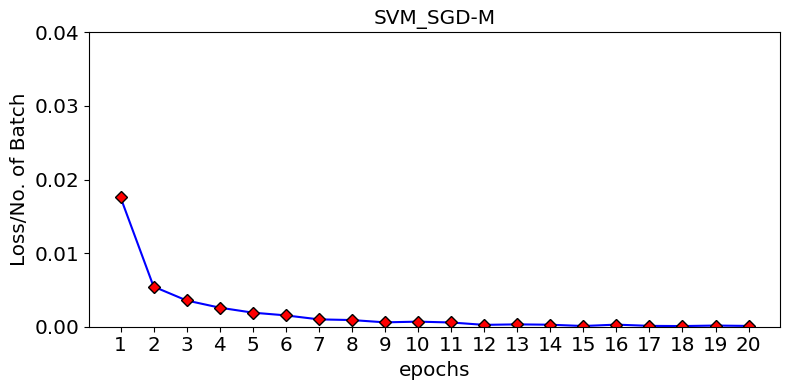

In [365]:
namehere = model_option + "_" + optimize_option

filename = namehere + ".pdf"

plt.rcParams["figure.figsize"] = [8.0,4.0]
plt.rcParams["figure.autolayout"] = True
plt.title(namehere)

x = list(range(1,21))    
plt.plot(x,loss_d_b, '-bD',  c='blue', mfc='red', mec='k')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("epochs", )
plt.ylabel("Loss/No. of Batch")
plt.ylim(0.0,0.04)
plt.savefig("./report/results/" + filename, format="pdf", bbox_inches="tight")
plt.show()


/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_59448/2603366543.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bD" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, accuracy_of_all, '-bD',  c='blue', mfc='red', mec='k')


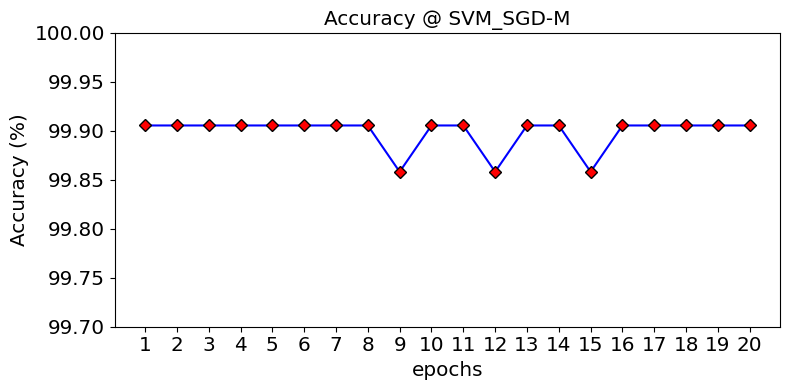

In [366]:
filename = namehere + "_accuracy" + ".pdf"

plt.rcParams["figure.figsize"] = [8.0,4.0]
plt.rcParams["figure.autolayout"] = True
plt.title("Accuracy @ " + namehere)

x = list(range(1,21))
plt.plot(x, accuracy_of_all, '-bD',  c='blue', mfc='red', mec='k')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("epochs", )
plt.ylabel("Accuracy (%)")
plt.ylim(99.70, 100)
plt.savefig("./report/results/" + filename, format="pdf", bbox_inches="tight")
plt.show()